Model Building for the  Customer Churn Prediction 

In [ ]:
# standard libraries
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

# libraries for model building
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import(train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (roc_auc_score,f1_score,precision_score, classification_report, 
                             confusion_matrix, roc_curve, recall_score,precision_recall_curve,make_scorer)

import optuna
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# VIF for feature selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8')
%matplotlib inline


All imports done!


In [ ]:
# models imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier





load processed and feature engineered data

In [ ]:

pd.set_option('display.max_columns',None)
ch=pd.read_csv(r'C:\first_data_science_proj\customer_churn_prediction\data\processed\churn_preprocessed_v2.csv')
ch.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,FiberOptic,Family,ProtectiveServices,StreamingAddict,ContractScore,PaymentRisk,HighCharges,AvgMonthlySpend,Newcustomer
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-1,0,1,1,0,3,4,0,14.925000,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2-4,0,0,2,0,2,3,0,53.985714,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-1,0,0,2,0,3,3,0,36.050000,1
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2-4,0,0,3,0,2,2,0,40.016304,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-1,1,0,0,0,3,4,1,50.550000,1


In [ ]:
# pipeline diagram
from sklearn import set_config
set_config(display='diagram')

In [5]:
# split data into X and y
x=ch.drop('Churn',axis=1)
y=ch['Churn']

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
print(f'train shape : {x_train.shape}, test shape: {x_test.shape}')
print(f'churn ration trai : {y_train.mean():.4f} , test : {y_test.mean():.4f}')

train shape : (5634, 29), test shape: (1409, 29)
 churn ration trai : 0.2654 , test : 0.2654


In [7]:
# identify categorical and numerical columns
cat_cols=x.select_dtypes(include='object').columns.tolist()
num_cols=x.select_dtypes(include=['int64','float64']).columns.tolist()

print(f'categorical columns:--> {len(cat_cols)}\n{cat_cols}\n')
print(f'numerical columns:--> {len(num_cols)}\n{num_cols}\n')

categorical columns:--> 17
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']

numerical columns:--> 12
['tenure', 'MonthlyCharges', 'TotalCharges', 'FiberOptic', 'Family', 'ProtectiveServices', 'StreamingAddict', 'ContractScore', 'PaymentRisk', 'HighCharges', 'AvgMonthlySpend', 'Newcustomer']



In [ ]:
#pipeline for the numerical and categorical preprocessing 
numeric_processor= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())])
from sklearn.preprocessing import OneHotEncoder
categorical_processor=Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('OneHot',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'))])

In [9]:
# combine the categorical and numerical processing techs
from sklearn.compose import ColumnTransformer
preprocessing_pipe=ColumnTransformer(transformers=[
    ('Numeric',numeric_processor,num_cols),
     ('Categorical',categorical_processor,cat_cols)
     ],remainder='drop'
)

In [10]:
preprocessing_pipe

,transformers,"[('Numeric', ...), ('Categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


model selection

In [ ]:
models = {
    'randomforest':RandomForestClassifier(n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]),
    
    'AdaBoost': AdaBoostClassifier()  
}

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    full_pipe = ImbPipeline(steps=[('preprocessor', preprocessing_pipe), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    scores = cross_val_score(full_pipe, x_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores.mean()
    print(f"{name} CV AUC: {scores.mean():.4f}")

best_model_name = max(results, key=results.get)
print(f"Best: {best_model_name} {results[best_model_name]:.4f}")  

randomforest CV AUC: 0.8351
GradientBoosting CV AUC: 0.8464
XGBoost CV AUC: 0.8238
AdaBoost CV AUC: 0.8429
Best: GradientBoosting 0.8464


the best model is gradientboosting but i selected the randomforest because it performace are good in small datasets gb,xgb,adaboost are good in medium and large datasets 

In [ ]:
from sklearn.metrics import make_scorer
recall_scorer = make_scorer(recall_score, pos_label=1)  

def objective(trial):
    params = {
        'n_estimators':trial.suggest_int("n_estimators", 200, 1000),
        'max_depth' : trial.suggest_int("max_depth", 5, 40),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 20),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10),
        'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }
    model = RandomForestClassifier(**params)  
    pipe = ImbPipeline(steps=[('preprocessor', preprocessing_pipe), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    scores = cross_val_score(pipe, x_train, y_train, cv=cv, scoring=recall_scorer, n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print(f"Best params: {best_params}")
print(f' with smote cv auc: {scores.mean():.4f}')

[I 2025-12-06 17:21:46,735] A new study created in memory with name: no-name-8abfb654-c9d2-4d7f-b6b3-c0467eda6f08
[I 2025-12-06 17:22:12,847] Trial 0 finished with value: 0.6254180602006689 and parameters: {'n_estimators': 326, 'max_depth': 33, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.6254180602006689.
[I 2025-12-06 17:22:23,730] Trial 1 finished with value: 0.7491638795986623 and parameters: {'n_estimators': 822, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7491638795986623.
[I 2025-12-06 17:22:28,848] Trial 2 finished with value: 0.6862876254180602 and parameters: {'n_estimators': 343, 'max_depth': 32, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.7491638795986623.
[I 2025-12-06 17:22:45,760] Trial 3 finished with value: 0.6454849498327759 and parameters: {'n_estimators': 826, 'max_depth': 24, 'm

Best params: {'n_estimators': 902, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'log2'}
 with smote cv auc: 0.8429


best model with pipeline

In [ ]:
best_model = RandomForestClassifier(**best_params)
final_pipe = ImbPipeline (steps=[('preprocessor',preprocessing_pipe),('smote',SMOTE(random_state=42)),('classifier',best_model)])
final_pipe.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numeric', ...), ('Categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


overfitting and underfitting checking

In [15]:
y_train_proba = final_pipe.predict_proba(x_train)[:, 1]
y_test_proba = final_pipe.predict_proba(x_test)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}, Diff: {train_auc - test_auc:.4f}")

Train AUC: 0.8593, Test AUC: 0.8439, Diff: 0.0154


vif analysis

In [16]:
x_train_trans = final_pipe.named_steps['preprocessor'].fit_transform(x_train)
vif_df = pd.DataFrame()
vif_df["feature"] = final_pipe.named_steps['preprocessor'].get_feature_names_out()
vif_df["VIF"] = [variance_inflation_factor(x_train_trans, i) for i in range(x_train_trans.shape[1])]
high_vif = vif_df[vif_df['VIF'] > 10]
print(high_vif)  # Drop if any, e.g., TotalCharges often high - remove from num_cols, recreate pipe

                                              feature         VIF
0                                     Numeric__tenure   13.192024
1                             Numeric__MonthlyCharges  891.062995
2                               Numeric__TotalCharges   13.836525
3                                 Numeric__FiberOptic         inf
5                         Numeric__ProtectiveServices         inf
6                            Numeric__StreamingAddict         inf
7                              Numeric__ContractScore         inf
8                                Numeric__PaymentRisk         inf
10                           Numeric__AvgMonthlySpend   40.955450
16                      Categorical__PhoneService_Yes   35.352592
18           Categorical__InternetService_Fiber optic         inf
19                    Categorical__InternetService_No  103.563462
20                    Categorical__OnlineSecurity_Yes         inf
21                      Categorical__OnlineBackup_Yes         inf
22        

threshold

In [17]:
y_proba = final_pipe.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1)]
print(f"Best threshold: {best_threshold:.2f}")
y_pred = (y_proba >= best_threshold).astype(int)

Best threshold: 0.56


roc,f1 and confustion matrix

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409

F1: 0.64, Recall: 0.74, Precision: 0.56, AUC: 0.84
[[820 215]
 [ 99 275]]


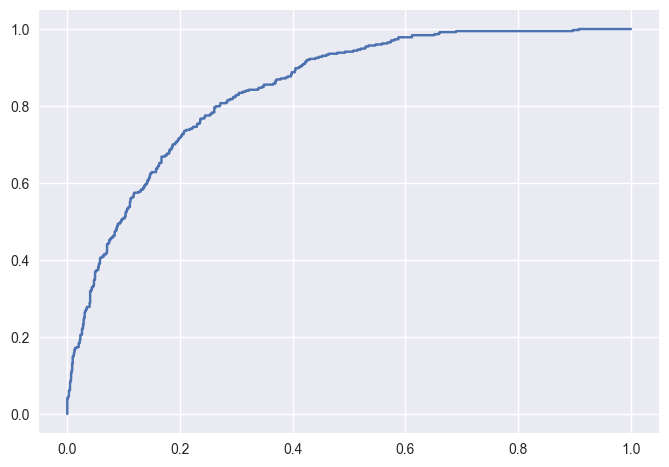

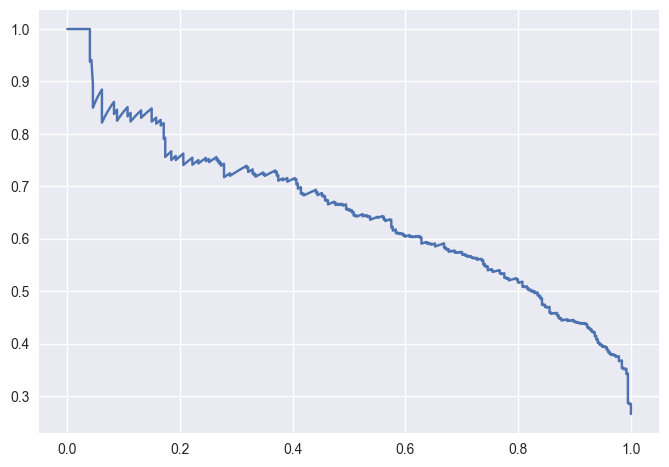

In [ ]:
print(classification_report(y_test, y_pred))
print(f"F1: {f1_score(y_test, y_pred):.2f}, Recall: {recall_score(y_test, y_pred):.2f}, Precision: {precision_score(y_test, y_pred):.2f}, AUC: {roc_auc_score(y_test, y_proba):.2f}")
print(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr); plt.show()
plt.plot(recall, precision); plt.show()


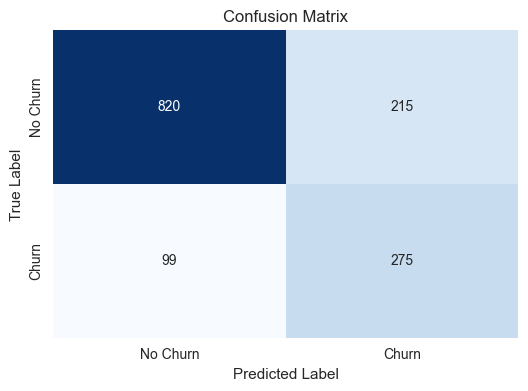

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

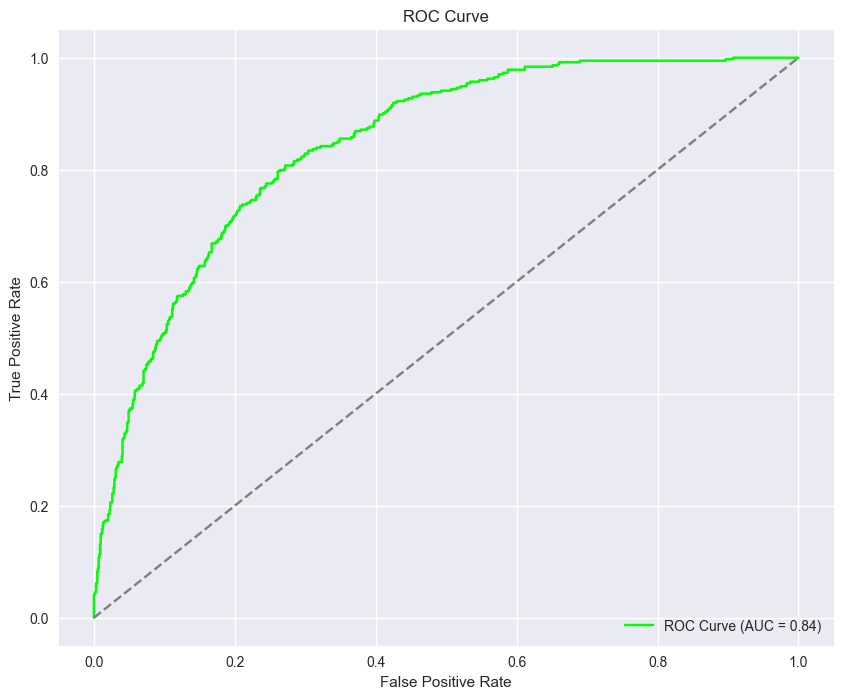

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='lime', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

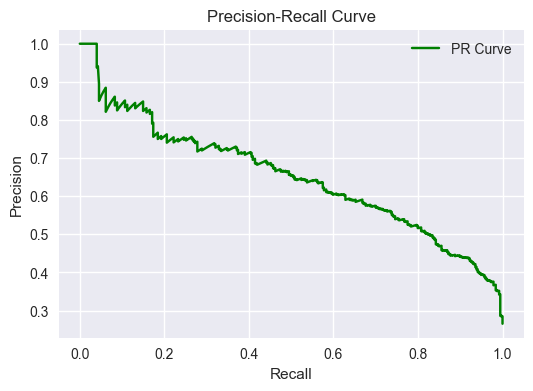

In [21]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

shap exaplanation by features importance

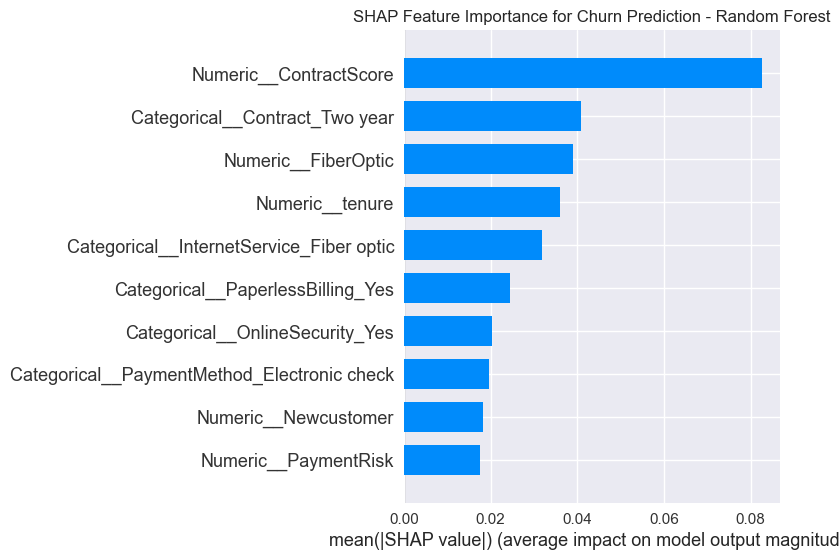

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# classifier from the pipeline
classifier = final_pipe.named_steps['classifier']

# transform the test data using the preprocessor
x_test_trans = final_pipe.named_steps['preprocessor'].transform(x_test)

#  treeExplainer for RandomForest
explainer = shap.TreeExplainer(classifier)

# compute shap values
shap_values = explainer.shap_values(x_test_trans)

#feature names
feature_names = final_pipe.named_steps['preprocessor'].get_feature_names_out()

# Handle different formats of shap_values
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:

    if shap_values.shape[2] == 2:  
        shap_values_class1 = shap_values[:, :, 1]
    else:
        raise ValueError("Unexpected number of classes.")
elif isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_class1 = shap_values[1]
    if shap_values_class1.shape[1] == len(feature_names) + 1:
        shap_values_class1 = shap_values_class1[:, :-1]
else:
    raise ValueError("Unexpected SHAP values shape. Adjust based on your model.")

#  bar plot for feature importance
shap.summary_plot(shap_values_class1, x_test_trans, feature_names=feature_names, plot_type='bar', max_display=10, show=False)
plt.title('SHAP Feature Importance for Churn Prediction - Random Forest')
plt.show()

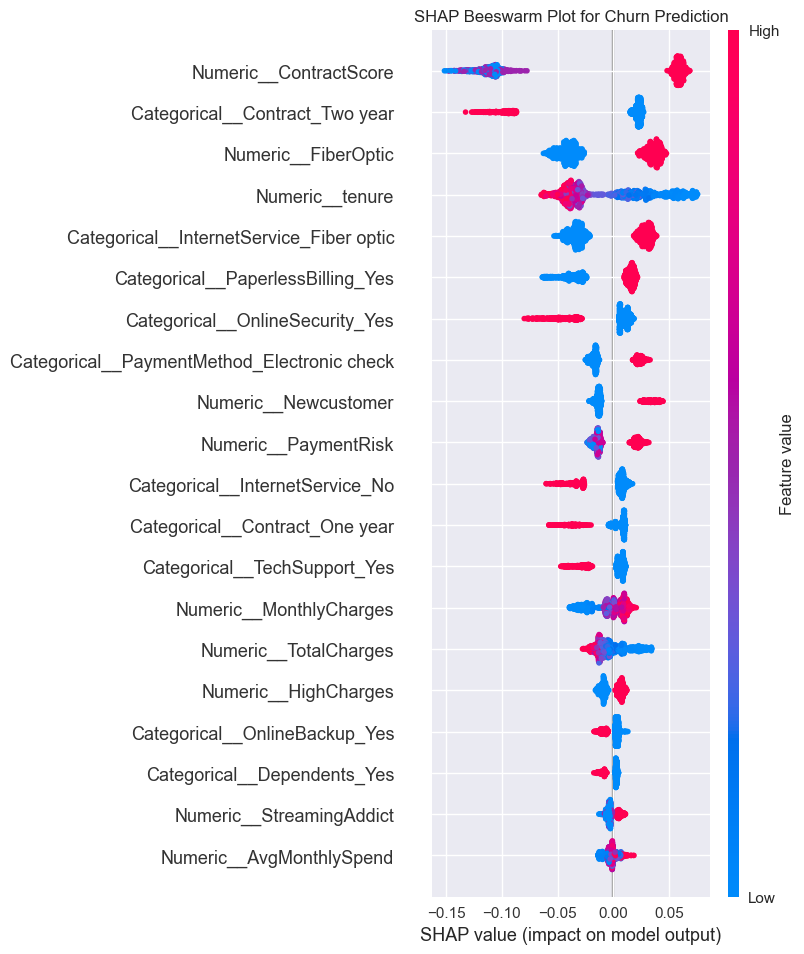

In [ ]:
# beeswarm plot
import shap

# classifier from the pipeline
classifier = final_pipe.named_steps['classifier']

# transform the test data using the preprocessor
x_test_trans = final_pipe.named_steps['preprocessor'].transform(x_test)

#  TreeExplainer for RandomForest
explainer = shap.TreeExplainer(classifier)

# compute SHAP values
shap_values = explainer.shap_values(x_test_trans)

# Beeswarm plot for class 1 (Churn) 
feature_names = final_pipe.named_steps['preprocessor'].get_feature_names_out()
shap.summary_plot(shap_values[:, :, 1], x_test_trans, feature_names=feature_names, plot_type="dot", show=False)
plt.title('SHAP Beeswarm Plot for Churn Prediction')
plt.show()

all plots are in one subplots pr,roc_curve,confusion matrix


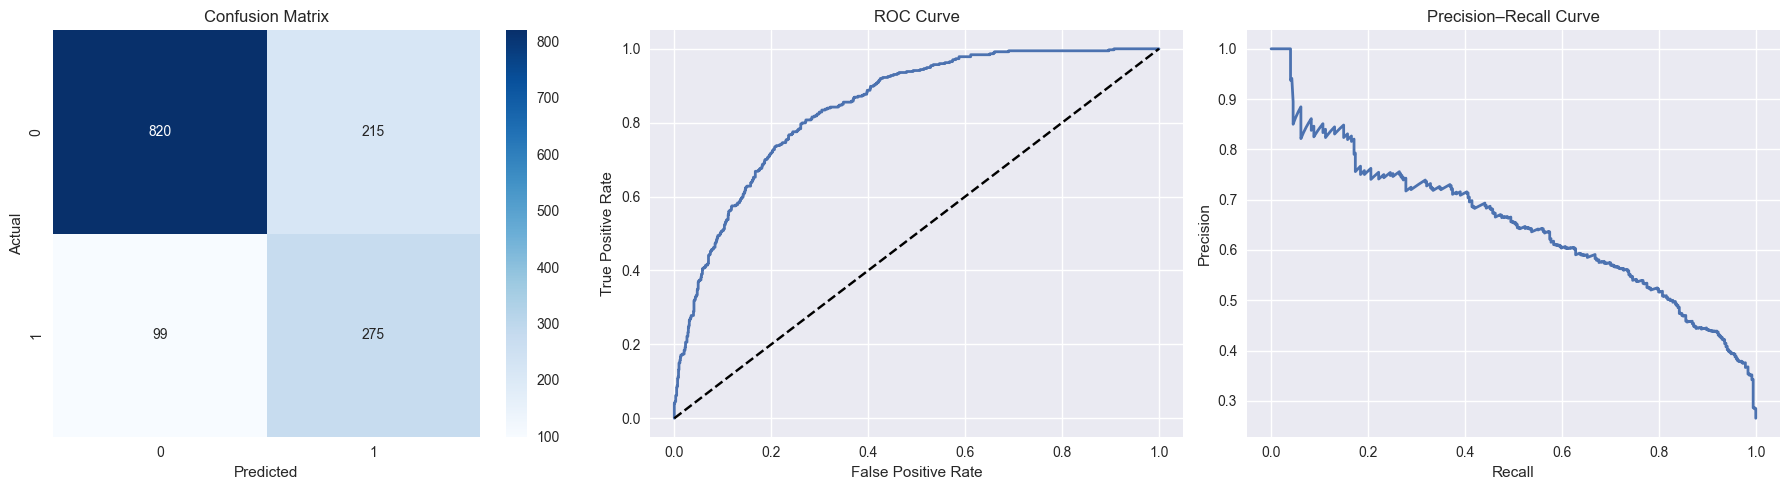

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# prediction
y_proba = final_pipe.predict_proba(x_test)[:, 1]
y_pred = (y_proba >= best_threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# plots
plt.figure(figsize=(18, 5))

# 1 Confusion Matrix plot
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 2 ROC Curve plot
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='lime',linewidth=2,label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

# 3 Precision–Recall Curve plot
plt.subplot(1, 3, 3)
plt.plot(recall, precision, linewidth=2)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

In [29]:
joblib.dump(final_pipe,r'C:\first_data_science_proj\customer_churn_prediction\models/churn_rf_models.pkl')
print('saved')

saved


model saved to models folder